## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

/Users/i033085/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


This was developed using Python 3.5.2 (Anaconda) and TensorFlow version:

In [2]:
tf.__version__

'1.7.0'

PrettyTensor version:

In [3]:
pt.__version__

'0.7.4'

## Load Data

In [4]:
from numpy import genfromtxt
train_data = genfromtxt('optdigits.tra', delimiter=',')
test_data = genfromtxt('optdigits.tes.txt', delimiter=',')

In [5]:
features_train = train_data[:, :-1].astype(np.float32)
features_test = test_data[:, :-1].astype(np.float32)

In [6]:
labels_train = train_data[:, -1:].astype(int)
labels_test =  test_data[:, -1:].astype(int)

In [7]:
onehot_labels_train = np.zeros((train_data.shape[0], 10))
for i in range(train_data.shape[0]):
    j = labels_train[i]
    onehot_labels_train[i,j] = 1
onehot_labels_test = np.zeros((test_data.shape[0], 10))
for i in range(test_data.shape[0]):
    j = labels_test[i]
    onehot_labels_test[i,j] = 1

In [8]:
test_labels_cls = np.argmax(onehot_labels_test, axis=1)

In [9]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(train_data)))
print("- Test-set:\t\t{}".format(len(test_data)))

Size of:
- Training-set:		3823
- Test-set:		1797


### Creating random training-sets

We will train 5 neural networks on different training-sets that are selected at random. 

In [10]:
combined_images = features_train
combined_labels = onehot_labels_train

Check that the shape of the combined arrays is correct.

In [11]:
print(combined_images.shape)
print(combined_labels.shape)

(3823, 64)
(3823, 10)


Size of the combined data-set.

In [12]:
combined_size = len(combined_images)
combined_size

3823

Define the size of the training-set used for each neural network. You can try and change this.

In [13]:
train_size = int(0.9 * combined_size)
train_size

3440

We do not use a validation-set during training, but this would be the size.

In [14]:
validation_size = combined_size - train_size
validation_size

383

Helper-function for splitting the combined data-set into a random training- and validation-set.

In [15]:
def random_training_set():
    # Create a randomized index into the full / combined training-set.
    idx = np.random.permutation(combined_size)

    # Split the random index into training- and validation-sets.
    idx_train = idx[0:train_size]
    idx_validation = idx[train_size:]

    # Select the images and labels for the new training-set.
    x_train = combined_images[idx_train, :]
    y_train = combined_labels[idx_train, :]

    # Select the images and labels for the new validation-set.
    x_validation = combined_images[idx_validation, :]
    y_validation = combined_labels[idx_validation, :]

    # Return the new training- and validation-sets.
    return x_train, y_train, x_validation, y_validation

## Data Dimensions

The data dimensions are used in several places in the source-code below. They are defined once so we can use these variables instead of numbers throughout the source-code below.

In [16]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 8

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [17]:
def plot_images(images,                  # Images to plot, 2-d array.
                cls_true,                # True class-no for images.
                ensemble_cls_pred=None,  # Ensemble predicted class-no.
                best_cls_pred=None):     # Best-net predicted class-no.

    assert len(images) == len(cls_true)
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if ensemble_cls_pred is None:
        hspace = 0.3
    else:
        hspace = 1.0
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # For each of the sub-plots.
    for i, ax in enumerate(axes.flat):

        # There may not be enough images for all sub-plots.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i].reshape(img_shape), cmap='binary')

            # Show true and predicted classes.
            if ensemble_cls_pred is None:
                xlabel = "True: {0}".format(cls_true[i])
            else:
                msg = "True: {0}\nEnsemble: {1}\nBest Net: {2}"
                xlabel = msg.format(cls_true[i],
                                    ensemble_cls_pred[i],
                                    best_cls_pred[i])

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

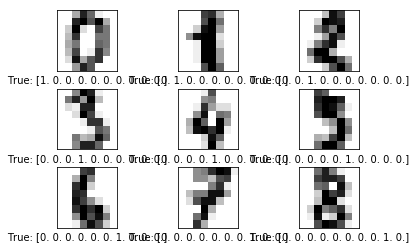

In [18]:
# Get the first images from the test-set.
images = features_test[0:9]

# Get the true classes for those images.
cls_true = onehot_labels_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [19]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [20]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [21]:
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

In [22]:
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


### Neural Network

In [23]:
x_pretty = pt.wrap(x_image)

In [24]:
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        conv2d(kernel=3, depth=8, name='layer_conv1').\
        max_pool(kernel=2, stride=2).\
        conv2d(kernel=3, depth=16, name='layer_conv2').\
        max_pool(kernel=2, stride=2).\
        flatten().\
        fully_connected(size=256, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



### Optimization Method

In [25]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

### Performance Measures

We need a few more performance measures to display the progress to the user.

First we calculate the predicted class number from the output of the neural network `y_pred`, which is a vector with 10 elements. The class number is the index of the largest element.

In [26]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [27]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

The classification accuracy is calculated by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then taking the average of these numbers.

In [28]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Saver


In [29]:
saver = tf.train.Saver(max_to_keep=100)

This is the directory used for saving and retrieving the data.

In [30]:
save_dir = 'checkpoints/'

Create the directory if it does not exist.

In [31]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

This function returns the save-path for the data-file with the given network number.

In [32]:
def get_save_path(net_number):
    return save_dir + 'network' + str(net_number)

## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [33]:
session = tf.Session()

### Initialize variables

The variables for `weights` and `biases` must be initialized before we start optimizing them. We make a simple wrapper-function for this, because we will call it several times below.

In [34]:
def init_variables():
    session.run(tf.initialize_all_variables())

### Helper-function to create a random training batch.

In [35]:
train_batch_size = 64

Function for selecting a random training-batch of the given size.

In [36]:
def random_batch(x_train, y_train):
    # Total number of images in the training-set.
    num_images = len(x_train)

    # Create a random index into the training-set.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = x_train[idx, :]  # Images.
    y_batch = y_train[idx, :]  # Labels.

    # Return the batch.
    return x_batch, y_batch

### Helper-function to perform optimization iterations

In [37]:
def optimize(num_iterations, x_train, y_train):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch(x_train, y_train)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations and after last iteration.
        if i % 100 == 0:

            # Calculate the accuracy on the training-batch.
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            
            # Status-message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Batch Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Create ensemble of neural networks

Number of neural networks in the ensemble.

In [38]:
num_networks = 5

Number of optimization iterations for each neural network.

In [39]:
num_iterations = 10000

Create the ensemble of neural networks. All networks use the same TensorFlow graph that was defined above. For each neural network the TensorFlow weights and variables are initialized to random values and then optimized. The variables are then saved to disk so they can be reloaded later.


In [40]:
if True:
    # For each of the neural networks.
    for i in range(num_networks):
        print("Neural network: {0}".format(i))

        # Create a random training-set. Ignore the validation-set.
        x_train, y_train, _, _ = random_training_set()

        # Initialize the variables of the TensorFlow graph.
        session.run(tf.global_variables_initializer())

        # Optimize the variables using this training-set.
        optimize(num_iterations=num_iterations,
                 x_train=x_train,
                 y_train=y_train)

        # Save the optimized variables to disk.
        saver.save(sess=session, save_path=get_save_path(i))

        # Print newline.
        print()

Neural network: 0
Optimization Iteration:      1, Training Batch Accuracy:  17.2%
Optimization Iteration:    101, Training Batch Accuracy:  28.1%
Optimization Iteration:    201, Training Batch Accuracy:  51.6%
Optimization Iteration:    301, Training Batch Accuracy:  68.8%
Optimization Iteration:    401, Training Batch Accuracy:  70.3%
Optimization Iteration:    501, Training Batch Accuracy:  82.8%
Optimization Iteration:    601, Training Batch Accuracy:  78.1%
Optimization Iteration:    701, Training Batch Accuracy:  90.6%
Optimization Iteration:    801, Training Batch Accuracy:  89.1%
Optimization Iteration:    901, Training Batch Accuracy:  90.6%
Optimization Iteration:   1001, Training Batch Accuracy:  93.8%
Optimization Iteration:   1101, Training Batch Accuracy:  93.8%
Optimization Iteration:   1201, Training Batch Accuracy:  93.8%
Optimization Iteration:   1301, Training Batch Accuracy:  95.3%
Optimization Iteration:   1401, Training Batch Accuracy:  93.8%
Optimization Iteration

Optimization Iteration:   2801, Training Batch Accuracy:  98.4%
Optimization Iteration:   2901, Training Batch Accuracy:  96.9%
Optimization Iteration:   3001, Training Batch Accuracy:  98.4%
Optimization Iteration:   3101, Training Batch Accuracy:  98.4%
Optimization Iteration:   3201, Training Batch Accuracy:  96.9%
Optimization Iteration:   3301, Training Batch Accuracy:  95.3%
Optimization Iteration:   3401, Training Batch Accuracy: 100.0%
Optimization Iteration:   3501, Training Batch Accuracy:  98.4%
Optimization Iteration:   3601, Training Batch Accuracy: 100.0%
Optimization Iteration:   3701, Training Batch Accuracy:  98.4%
Optimization Iteration:   3801, Training Batch Accuracy:  98.4%
Optimization Iteration:   3901, Training Batch Accuracy:  93.8%
Optimization Iteration:   4001, Training Batch Accuracy: 100.0%
Optimization Iteration:   4101, Training Batch Accuracy:  98.4%
Optimization Iteration:   4201, Training Batch Accuracy:  98.4%
Optimization Iteration:   4301, Training

Optimization Iteration:   5601, Training Batch Accuracy: 100.0%
Optimization Iteration:   5701, Training Batch Accuracy: 100.0%
Optimization Iteration:   5801, Training Batch Accuracy: 100.0%
Optimization Iteration:   5901, Training Batch Accuracy: 100.0%
Optimization Iteration:   6001, Training Batch Accuracy:  96.9%
Optimization Iteration:   6101, Training Batch Accuracy: 100.0%
Optimization Iteration:   6201, Training Batch Accuracy: 100.0%
Optimization Iteration:   6301, Training Batch Accuracy: 100.0%
Optimization Iteration:   6401, Training Batch Accuracy: 100.0%
Optimization Iteration:   6501, Training Batch Accuracy: 100.0%
Optimization Iteration:   6601, Training Batch Accuracy:  98.4%
Optimization Iteration:   6701, Training Batch Accuracy: 100.0%
Optimization Iteration:   6801, Training Batch Accuracy:  98.4%
Optimization Iteration:   6901, Training Batch Accuracy: 100.0%
Optimization Iteration:   7001, Training Batch Accuracy: 100.0%
Optimization Iteration:   7101, Training

Optimization Iteration:   8401, Training Batch Accuracy: 100.0%
Optimization Iteration:   8501, Training Batch Accuracy: 100.0%
Optimization Iteration:   8601, Training Batch Accuracy: 100.0%
Optimization Iteration:   8701, Training Batch Accuracy: 100.0%
Optimization Iteration:   8801, Training Batch Accuracy: 100.0%
Optimization Iteration:   8901, Training Batch Accuracy: 100.0%
Optimization Iteration:   9001, Training Batch Accuracy: 100.0%
Optimization Iteration:   9101, Training Batch Accuracy: 100.0%
Optimization Iteration:   9201, Training Batch Accuracy: 100.0%
Optimization Iteration:   9301, Training Batch Accuracy: 100.0%
Optimization Iteration:   9401, Training Batch Accuracy: 100.0%
Optimization Iteration:   9501, Training Batch Accuracy: 100.0%
Optimization Iteration:   9601, Training Batch Accuracy: 100.0%
Optimization Iteration:   9701, Training Batch Accuracy: 100.0%
Optimization Iteration:   9801, Training Batch Accuracy: 100.0%
Optimization Iteration:   9901, Training

In [41]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_labels(images):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted labels which
    # will be calculated in batches and filled into this array.
    pred_labels = np.zeros(shape=(num_images, num_classes),
                           dtype=np.float)

    # Now calculate the predicted labels for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images between index i and j.
        feed_dict = {x: images[i:j, :]}

        # Calculate the predicted labels using TensorFlow.
        pred_labels[i:j] = session.run(y_pred, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    return pred_labels

Calculate a boolean array whether the predicted classes for the images are correct.

In [42]:
def correct_prediction(images, labels, cls_true):
    # Calculate the predicted labels.
    pred_labels = predict_labels(images=images)

    # Calculate the predicted class-number for each image.
    cls_pred = np.argmax(pred_labels, axis=1)

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)
    print(correct)

    return correct

Calculate a boolean array whether the images in the test-set are classified correctly.

In [43]:
def test_correct():
    return correct_prediction(images = features_test,
                              labels = onehot_labels_test,
                              cls_true = test_labels_cls)

Calculate a boolean array whether the images in the validation-set are classified correctly.

### Helper-functions for calculating the classification accuracy

This function calculates the classification accuracy given a boolean array whether each image was correctly classified. E.g. `classification_accuracy([True, True, False, False, False]) = 2/5 = 0.4`

In [44]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.
    return correct.mean()

Calculate the classification accuracy on the test-set.

In [45]:
def test_accuracy():
    # Get the array of booleans whether the classifications are correct
    # for the test-set.
    correct = test_correct()
    
    # Calculate the classification accuracy and return it.
    return classification_accuracy(correct)

## Results and analysis

Function for calculating the predicted labels for all the neural networks in the ensemble. The labels are combined further below.

In [46]:
def ensemble_predictions():
    # Empty list of predicted labels for each of the neural networks.
    pred_labels = []

    # Classification accuracy on the test-set for each network.
    test_accuracies = []

    

    # For each neural network in the ensemble.
    for i in range(num_networks):
        # Reload the variables into the TensorFlow graph.
        saver.restore(sess=session, save_path=get_save_path(i))

        # Calculate the classification accuracy on the test-set.
        test_acc = test_accuracy()
        

        # Append the classification accuracy to the list.
        test_accuracies.append(test_acc)

        # Print status message.
        msg = "Network: {0}, Accuracy on  Test-Set: {1:.4f}"
        print(msg.format(i, test_acc))

        # Calculate the predicted labels for the images in the test-set.
        # This is already calculated in test_accuracy() above but
        # it is re-calculated here to keep the code a bit simpler.
        pred = predict_labels(images=features_test)

        # Append the predicted labels to the list.
        pred_labels.append(pred)
    
    return np.array(pred_labels), \
           np.array(test_accuracies)

In [47]:
pred_labels, test_accuracies = ensemble_predictions()

INFO:tensorflow:Restoring parameters from checkpoints/network0
[ True  True False ...  True  True  True]
Network: 0, Accuracy on  Test-Set: 0.9416
INFO:tensorflow:Restoring parameters from checkpoints/network1
[ True  True  True ...  True  True  True]
Network: 1, Accuracy on  Test-Set: 0.9321
INFO:tensorflow:Restoring parameters from checkpoints/network2
[ True  True False ...  True  True  True]
Network: 2, Accuracy on  Test-Set: 0.9610
INFO:tensorflow:Restoring parameters from checkpoints/network3
[ True  True  True ...  True  True  True]
Network: 3, Accuracy on  Test-Set: 0.9494
INFO:tensorflow:Restoring parameters from checkpoints/network4
[ True  True  True ...  True  True  True]
Network: 4, Accuracy on  Test-Set: 0.9572


Summarize the classification accuracies on the test-set for the neural networks in the ensemble.

In [48]:
print("Mean test-set accuracy: {0:.4f}".format(np.mean(test_accuracies)))
print("Min test-set accuracy:  {0:.4f}".format(np.min(test_accuracies)))
print("Max test-set accuracy:  {0:.4f}".format(np.max(test_accuracies)))

Mean test-set accuracy: 0.9482
Min test-set accuracy:  0.9321
Max test-set accuracy:  0.9610


The predicted labels of the ensemble is a 3-dim array, the first dim is the network-number, the second dim is the image-number, the third dim is the classification vector.

In [49]:
pred_labels.shape

(5, 1797, 10)

### Ensemble predictions

In [50]:
ensemble_pred_labels = np.mean(pred_labels, axis=0)
ensemble_pred_labels.shape

(1797, 10)

The ensemble's predicted class number is then the index of the highest number in the label, which is calculated using argmax as usual.

In [51]:
ensemble_cls_pred = np.argmax(ensemble_pred_labels, axis=1)
ensemble_cls_pred.shape

(1797,)

Boolean array whether each of the images in the test-set was correctly classified by the ensemble of neural networks.

In [68]:
ensemble_correct = (ensemble_cls_pred == test_labels_cls)
ensemble_correct.size

1797

Negate the boolean array so we can use it to lookup incorrectly classified images.

In [69]:
ensemble_incorrect = np.logical_not(ensemble_correct)

1797

In [70]:
np.sum(ensemble_correct)

1741

### Ensemble Accuracy


In [75]:
np.true_divide(np.sum(ensemble_correct),ensemble_correct.size)

0.9688369504730105

### Best neural network

Now we find the single neural network that performed best on the test-set.

First list the classification accuracies on the test-set for all the neural networks in the ensemble.

In [54]:
test_accuracies

array([0.94156928, 0.93210907, 0.96104619, 0.94936004, 0.95715081])

The index of the neural network with the highest classification accuracy.

In [55]:
best_net = np.argmax(test_accuracies)
best_net

2

The best neural network's classification accuracy on the test-set.

In [56]:
test_accuracies[best_net]

0.9610461880912632

Predicted labels of the best neural network.

In [57]:
best_net_pred_labels = pred_labels[best_net, :, :]

The predicted class-number.

In [58]:
best_net_cls_pred = np.argmax(best_net_pred_labels, axis=1)

Boolean array whether the best neural network classified each image in the test-set correctly.

In [59]:
best_net_correct = (best_net_cls_pred == test_labels_cls)

Boolean array whether each image is incorrectly classified.

In [60]:
best_net_incorrect = np.logical_not(best_net_correct)

### Comparison of ensemble vs. the best single network

The number of images in the test-set that were correctly classified by the ensemble.

In [61]:
np.sum(ensemble_correct)

1741

The number of images in the test-set that were correctly classified by the best neural network.

In [62]:
np.sum(best_net_correct)

1727

Boolean array whether each image in the test-set was correctly classified by the ensemble and incorrectly classified by the best neural network.

In [63]:
ensemble_better = np.logical_and(best_net_incorrect,
                                 ensemble_correct)

Number of images in the test-set where the ensemble was better than the best single network:

In [64]:
ensemble_better.sum()

40

Boolean array whether each image in the test-set was correctly classified by the best single network and incorrectly classified by the ensemble.

In [65]:
best_net_better = np.logical_and(best_net_correct,
                                 ensemble_incorrect)

Number of images in the test-set where the best single network was better than the ensemble.

In [66]:
best_net_better.sum()

26